In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2
%run fix_paths.ipy

Populating the interactive namespace from numpy and matplotlib
/workspace/srp-boxes


In [2]:
import srp.config as C
import pandas as pd
from srp.data.orientedboundingbox import OrientedBoundingBox

In [3]:
import os
import rasterio
import affine

In [83]:
from skimage.transform import rotate
class DataAugment:
    def __init__(self, radius=C.PATCH_SIZE):
        self.densityfile = C.VOLUMETRIC_PATH
        self.colorfile = C.COLOR_PATH
        self.radius = radius/2
        self.poscsvdir = os.path.join(C.CSV_DIR, 'positives_{}.csv'.format(C.VOLUME_DEFAULT_CRS.replace(':', '')))
        self.negcsvdir = os.path.join(C.CSV_DIR, 'negatives_{}.csv'.format(C.VOLUME_DEFAULT_CRS.replace(':', '')))
        self.posinfo = pd.read_csv(self.poscsvdir)
        self.neginfo = pd.read_csv(self.negcsvdir)
        
        self.densities = rasterio.open(self.densityfile)
        self.colors = rasterio.open(self.colorfile)
    
    def get_patch_xy(self, x, y, radius_in_pixels=None):
        R = int(radius_in_pixels or self.radius)
        c, r = np.asarray(~self.densities.transform*(x, y)).astype(int)
        
        window = ((r-R, r+R), (c-R, c+R))
        bounds = self.densities.window_bounds(window)
        
        densities = self.densities.read(window=window,
                                        boundless=True,
                                        out=np.zeros((self.densities.meta['count'], 2*R, 2*R),
                                                     dtype=np.uint16)).astype(np.float32)
        colors = self.colors.read((1,2,3),
                                  window=self.colors.window(*bounds),
                                  boundless=True,
                                  out=np.zeros((3, 2*R, 2*R), dtype=np.uint8)).astype(np.float32)/255.

        return np.concatenate((colors, densities)) 
    
    def get_patch_xyr(self, x, y, dx, dy, angle, radius_in_pixels=None):
        """
        
        
        x, y: coordinate in the original crs(epsg:26949) in meters
        dx, dy: x and y offsets in pixel
        angle: in degrees, the additional rotation we apply on the image
        radius_in_pixels: half the width of the output patch
        
        return: a rotated cropped image 
        """
        R = radius_in_pixels or radius_in_pixels
        dx, dy = int(dx), int(dy)
        source_patch = self.get_patch_xy(x, y, R * 2)
        rotated_patch = source_patch.copy()
        for i in range(len(source_patch)):
            rotated_patch[i] = rotate(source_patch[i], angle,
                                                        preserve_range=True)

        cropped_patch = rotated_patch[:, R + dy: 3*R + dy, R - dx : 3 * R - dx]
        
        return cropped_patch

In [84]:
da = DataAugment()
posinfo = pd.read_csv(da.poscsvdir).values
neginfo = pd.read_csv(da.negcsvdir).values

In [25]:
METER_PER_PIXEL = (da.densities.bounds.top - da.densities.bounds.bottom)/da.densities.shape[0]

In [102]:
with fiona.open(C.ANNOTATION_PATH) as vectorFile:
            hotspots = np.array([
                f['geometry']['coordinates'] for f in vectorFile
                if f['geometry'] is not None
            ])

In [114]:
da.colors.transform

Affine(0.0762000000000344, 0.0, 231616.07220000058,
       0.0, -0.0762000000000344, 252585.62640000123)

In [113]:
da.densities.transform

Affine(0.049948355054722254, 0.0, 231600.00051125194,
       0.0, -0.049996496002872315, 252599.9990879348)

In [124]:
posinfo[:,2]

array([  8.82642954e+01,   2.13197406e+01,   8.80745398e+01,
         5.01596456e+01,   8.99740805e+01,   8.92658258e+01,
         1.02462441e+01,   1.40392428e+01,   2.11541843e+00,
         1.10653254e-01,   8.93581160e+01,   5.38078856e+01,
         5.29268147e+01,   2.37388601e+01,   5.73194073e+01,
         8.61189384e+01,   6.01409484e-01,   2.21936308e-01,
         1.07380110e+00,   8.95037635e+01,   5.77914589e+01,
         5.67036450e+01,   5.93484416e+01,   2.20232856e+01,
         5.93481167e+01,   6.28393230e+01,   5.66093348e+01,
         8.34543030e+01,   2.40666960e+00,   8.93827092e+01,
         1.10156850e-01,   8.95363636e+01,   8.95286535e+01,
         7.10435587e+01,   6.86005775e+01,   1.65854003e+00,
         1.54513686e+00,   7.16186133e-01,   1.28464891e+01,
         1.56446624e+01,   7.25301334e-01,   8.94349767e+01,
         8.78851282e+01,   2.09033182e+01,   2.06014918e+01,
         2.23669248e+01,   2.37519060e+01,   1.08055478e-01,
         5.71363517e+01,

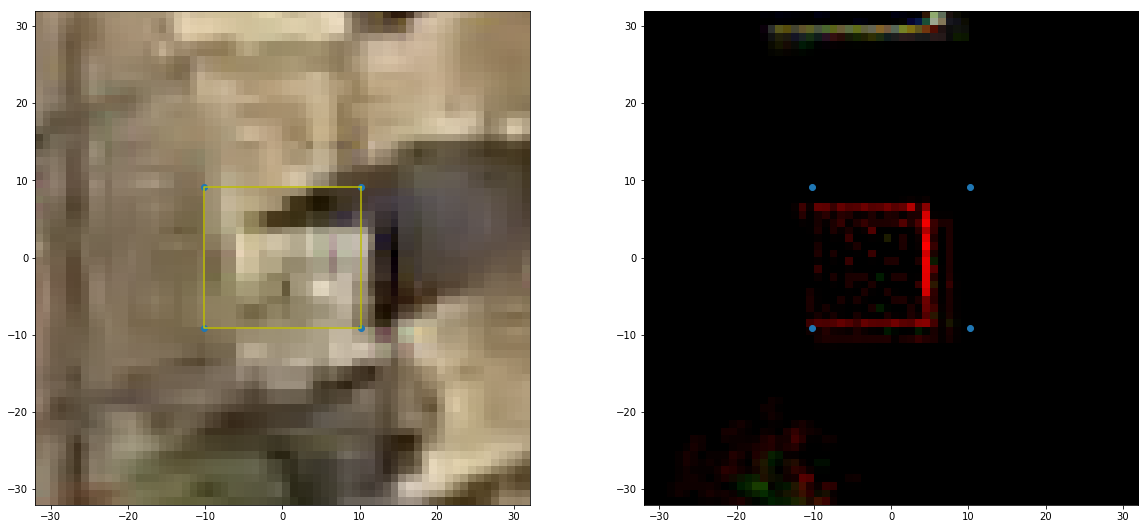

In [169]:
# pos
idx = np.random.randint(len(da.posinfo))
# idx = 15

# dx = int(np.random.randn() * C.MAX_OFFSET / METER_PER_PIXEL)
# dy = int(np.random.randn() * C.MAX_OFFSET / METER_PER_PIXEL)
dx, dy = 0, 0
# rotate_angle = np.random.rand() * 360         # or 90? 90 is easier to calculate
rotate_angle = 0
# expected_angle = 
angle, length, width = posinfo[idx,2], posinfo[idx,3], posinfo[idx,4]
cropped_patch = da.get_patch_xyr(posinfo[idx,0], 
                                 posinfo[idx,1], 
                                 dx, 
                                 dy, 
                                 -posinfo[idx, 2] + rotate_angle, 
                                 radius_in_pixels=32)

before = OrientedBoundingBox.from_rot_length_width((0,0), rotate_angle, length, width)
before2 = OrientedBoundingBox.from_rot_length_width((0,0), angle, length, width)

T = affine.Affine.translation(dx, dy)
R = affine.Affine.rotation(rotate_angle)
S = ~affine.Affine.scale(METER_PER_PIXEL)
A = T * R * S # S * R * T
after = np.vstack(A * before.points().T).T
after = OrientedBoundingBox.from_points(after)


figsize(20,20)
subplot(2,2,1)
imshow(cropped_patch[:3].transpose(1,2,0), extent=(-32,32,-32,32))
scatter(*after.points().T)
plot(*after.points()[(0,1,2,3,0),:].T, color='y')
subplot(2,2,2)
imshow(Normalize()(cropped_patch[5:8]).transpose(1,2,0), extent=(-32,32,-32,32),vmax=22, vmin=0)
scatter(*after.points().T)


# original_sample = da.get_patch_xy(posinfo[idx,0], posinfo[idx,1], radius_in_pixels=32)
# pixel_points = np.vstack(S * before2.points().T).T
# subplot(2,2,3)
# imshow(original_sample[:3].transpose(1,2,0), extent=(-32,32,-32,32))
# scatter(*pixel_points.T)
# plot(*pixel_points[(0,1,2,3,0),:].T, color='y')
# subplot(2,2,4)
# imshow(Normalize()(original_sample[5:8]).transpose(1,2,0), extent=(-32,32,-32,32),vmax=22, vmin=0)
# scatter(*pixel_points.T)
# x,y = S*(hotspots[idx]-posinfo[idx,:2]).T
# mark = np.vstack((x,y)).T
# scatter(*mark.T, color='r')

In [72]:
import fiona

In [77]:
f =  fiona.open(C.ANNOTATION_PATH) 

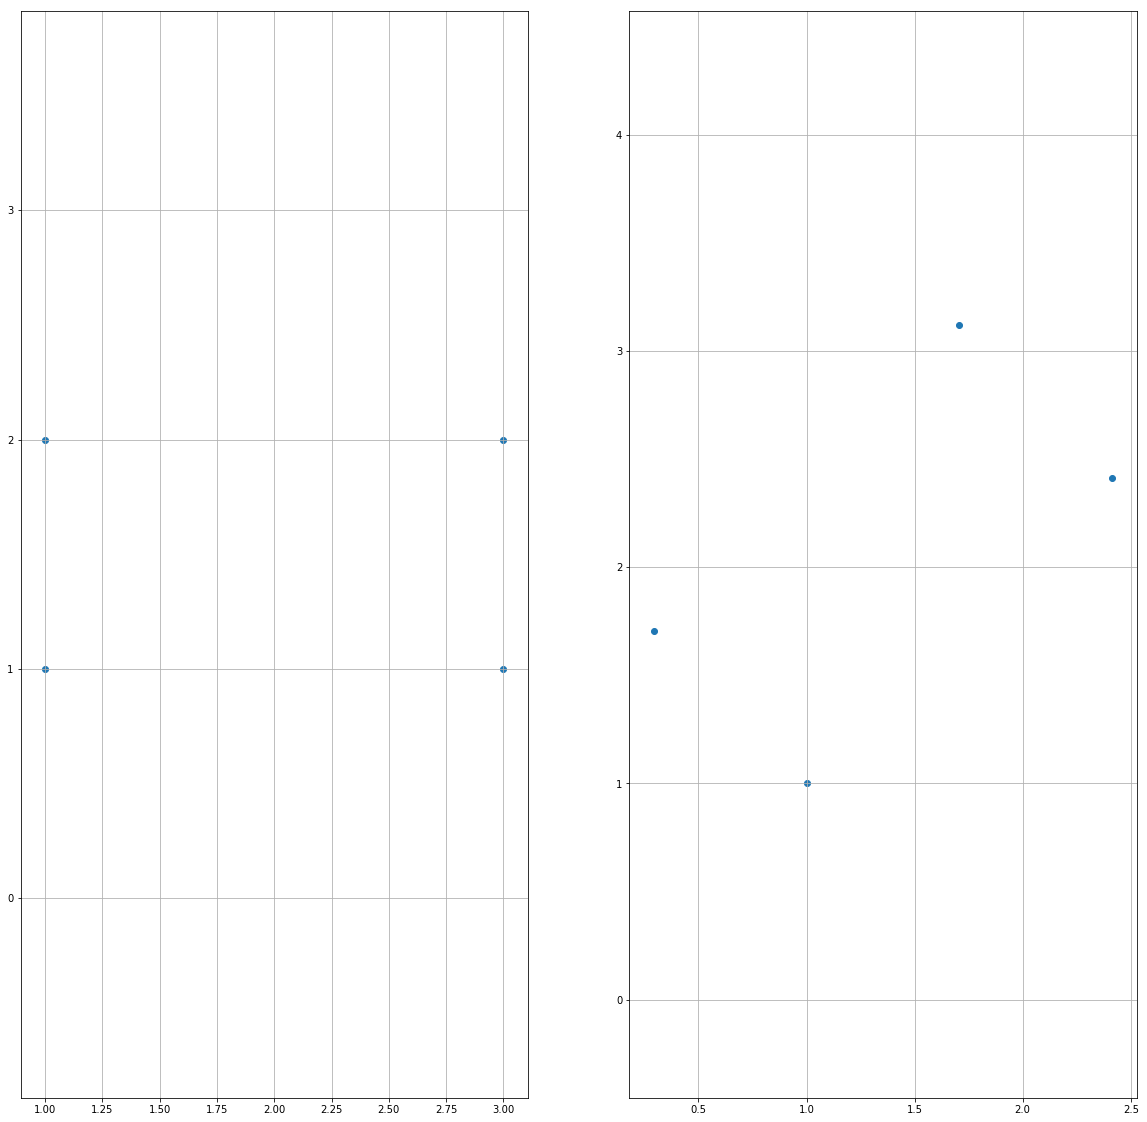

In [65]:
R  = affine.Affine.rotation(45)
T = affine.Affine.translation(1, 1)
box = np.array([[0,0], [0,1], [2,1], [2,0]])
subplot(1,2,1)
x, y = T * box.T
scatter(x, y)
ob = OrientedBoundingBox.from_points(box)
grid()
plt.axis('equal')

subplot(1,2,2)


A = T * R
transformed_box = OrientedBoundingBox.from_points(np.vstack(T * R *(box.T)).T)

scatter(*transformed_box.points().T)
plt.axis('equal')
grid()

In [311]:
def gen_pos_aug_patch(idx, max_offset=C.MAX_OFFSET, max_rot=360):
    
    aug_patch_rot = np.random.rand() * max_rot
    aug_patch_x = np.random.randn() * max_offset
    aug_patch_y = np.random.rand() * max_offset
    
    row = pos_info[idx]
    cropped = get_patch_xyr(row[0], row[1], aug_patch_x, aug_patch_y, row[2]+aug_patch_rot, 32)
    obb = OrientedBoundingBox.from_rot_length_width((row[0], row[1]), row[2], row[3], row[4])
    
    T = affine.Affine.translation(aug_patch_x, aug_patch_y)
    R = affine.Affine.rotation(aug_patch_rot)
    A = ~(T * R)
    
    transformed_box = OrientedBoundingBox.from_points(np.vstack(A *(obb.points().T)).T - np.array((row[0], row[1])))
    
    return Patch(transformed_box, cropped[:3], cropped[3:]), (aug_patch_rot, aug_patch_x, aug_patch_y)
    
    # return new_meta, A
    

In [54]:
from sklearn.model_selection import KFold

The "simple" thing to me is the following:
- we generate files that are all the same size (e.g. 96 by 96)       [_we can totally do this using old code_]
- we keep a record of how each file was generated from the raw input
- we keep a record that tells us what the net should predict when given that small file

In [65]:
kf = KFold(n_splits=C.FOLDS, shuffle=True, random_state=C.FOLD_RANDOM_SEED)

In [66]:
for train_index, test_index in kf.split(hotspots):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    pos_train, pos_test = hotspots[train_index], hotspots[test_index]
    

('TRAIN:', 156, 'TEST:', 40)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
('TRAIN:', 157, 'TEST:', 39)
